In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import pandas as pd
from pathlib import Path
import tensorflow_io as tfio
import ast
from pathlib import Path

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

from sklearn.model_selection import train_test_split

**Create Dataset**

In [2]:
SOUND = os.path.join('..', 'Generator', 'audiodata')
SOUND

'..\\Generator\\audiodata'

In [3]:
import re 
import glob

txtfiles = []
for file in glob.glob(SOUND+'\*.wav'):
    txtfiles.append(file)
sound = sorted(txtfiles, key=lambda s: int(re.search(r'\d+', s).group()))


In [4]:
decay = pd.read_csv('../Generator/audiodata/data.csv')['decay'].tolist()

data = list(zip(sound,decay))

**Build Preprocessing Function to Convert to RMS**

In [5]:
import librosa

def preprocess(file_path): 
    y, _ = librosa.load(file_path)
    rms = librosa.feature.rms(y=y)[0]
    
    return rms

**Create Training and Testing Partitions**

In [6]:
rms = list()
lables = list()

for file,lable in data:
    rms.append(preprocess(file))
    lables.append(lable)

rms = np.array(rms)
lables = np.array(lables)

In [7]:
train_x, test_x, train_y, test_y = train_test_split(rms, lables, test_size=0.3, random_state=10000)

**Build Model**

In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(173,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [10]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               22272     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38,913
Trainable params: 38,913
Non-trainable params: 0
_________________________________________________________________


**Train**

In [11]:
hist = model.fit(train_x, train_y, epochs=12, validation_data=(test_x,test_y))

Epoch 1/12
219/219 [==============================] - 1s 3ms/step - loss: 0.0833 - recall: 0.3700 - precision: 0.9988 - val_loss: 0.0706 - val_recall: 0.3872 - val_precision: 0.9991
Epoch 2/12
219/219 [==============================] - 0s 2ms/step - loss: 0.0681 - recall: 0.3813 - precision: 1.0000 - val_loss: 0.0656 - val_recall: 0.5323 - val_precision: 0.9987
Epoch 3/12
219/219 [==============================] - 0s 2ms/step - loss: 0.0619 - recall: 0.4014 - precision: 0.9993 - val_loss: 0.0590 - val_recall: 0.4159 - val_precision: 0.9992
Epoch 4/12
219/219 [==============================] - 0s 2ms/step - loss: 0.0586 - recall: 0.4222 - precision: 0.9990 - val_loss: 0.0567 - val_recall: 0.3888 - val_precision: 0.9991
Epoch 5/12
219/219 [==============================] - 0s 2ms/step - loss: 0.0561 - recall: 0.4328 - precision: 0.9993 - val_loss: 0.0550 - val_recall: 0.4390 - val_precision: 0.9985
Epoch 6/12
219/219 [==============================] - 0s 2ms/step - loss: 0.0544 - recall:

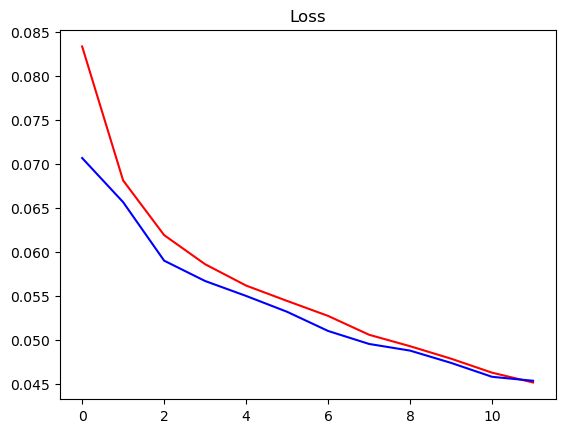

In [12]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

**Test Model with a Single Clip**

In [13]:

test_y

array([0.88, 0.65, 0.02, ..., 0.41, 0.18, 0.03])

In [14]:
yhat = model.predict(test_x)
yhat

94/94 [==============================] - 0s 1ms/step


array([[0.6158496 ],
       [0.82419264],
       [0.33740354],
       ...,
       [0.40105787],
       [0.14124686],
       [0.37946972]], dtype=float32)

In [15]:
score = model.evaluate(test_x,test_y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

94/94 [==============================] - 0s 1ms/step - loss: 0.0453 - recall: 0.5634 - precision: 0.9982
Test loss: 0.04531381279230118
Test accuracy: 0.5633567571640015


In [16]:
model_json = model.to_json()
with open("decay.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("decay.h5")